In [1]:
# imports
from typing import List
from datetime import datetime

import cv2
import os
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# constants
VALID_CHAR_REGEX = "[A-Z0-9]"
VALID_CHAR_CZECH_REGEX = "[a-zA-ZáčďéěíňóřšťúůýžÁČĎÉĚÍŇÓŘŠŤÚŮÝŽ]" # czech lang
VALID_CHAR_POLISH_REGEX = "[a-zA-ZąćęłńóśżźĄĆĘŁŃÓŚŻŹ]" # polish lang
VALID_CHAR_GERMAN_REGEX = "[a-zA-ZÄäÖöÜüẞß]" # german lang
VALID_CHAR_ENGLISH_REGEX = "[a-zA-Z]"
INVALID_CHAR_REGEX = "[.,()«»?!-—:;…]"
WOJNICZ_INPUT_FILE = "inputs\\wojnicz.txt"
REAL_INPUT_FILE = "inputs\\dinosauri-clean.txt"
DPI = 1
FIGSIZE = (1200/DPI, 400/DPI)

VALID_CHAR_REAL_REGEX = VALID_CHAR_CZECH_REGEX

In [3]:
# def function: save list of strings to file, separated by newlines
def save_to_file(input: List[str], path: str):
    file = open(path, "w")
    for line in input[:-1]:
        file.write(line + "\n")
    file.write(input[-1])
    file.close()
    

In [4]:
def plot_occ(input: dict[str, int], filename: str):
    # generate occurance count graph
    plt.plot(range(500), list(input.values())[:500], 'o', color='#444499')
    plt.plot(range(200), list(input.values())[:200], 'o', color='#8888ff')

    # save plot to file and show
    if filename == "":
        filename = datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.savefig("outputs\\occurance_" + filename + ".png")
    plt.show()
    

In [5]:
# def function: plot zipf numbers
def plot_zipf(input: dict[str, float], filename: str):
    sum = np.sum(list(input.values()))
    avg = np.average(list(input.values())[:200])
    avg_mid = np.average(list(input.values())[50:200])
    first = 0
    for z in input.values():
        first += 1
        if z >= avg:
            break

    print("Average value of first 200 items (highlighted):  ", avg)
    print("Average value of 50th to 200th item:             ", avg_mid)
    print("Index of first item to reach the average:        ", first)
    
    plt.plot(list(input.values())[:500], "#444499", label="Zipf values")
    plt.plot(list(input.values())[:200], "#8888ff", label="Zipf values (first 200)")
    plt.plot([avg for i in range(500)], "#ff1155", label="Average of first 200 Zipf values")
    plt.plot([avg_mid for i in range(500)], "#ff9944", label="Average of 50th to 200th Zipf values")
    plt.legend()

    if filename == "":
        filename = datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.savefig("outputs\\zipf_" + filename + ".png")
    plt.show()

## Cleaning text file

Removing all unnecesary lines and characters from input file.

The end result is a text file with only lines containing words and no dashes at the end of the line.  
Each line is separated by newline '<code>\n</code>'  
Each word within line is separated by comma '<code>,</code>'  
  
Output is saved to <code>cleaned.txt</code>

In [6]:
# open input text
# https://www.ic.unicamp.br/~stolfi/voynich/mirror/reeds/docs/FSG.txt
text = open(WOJNICZ_INPUT_FILE, 'r').read().split("\n")

In [7]:
# remove lines with no text
parsed = []

for line in text:
    if line == "":
        continue
    if line == "\x0c":
        continue
    if line.startswith("#"):
        continue
    if not re.search(VALID_CHAR_REGEX, line):
        continue

    parsed.append(line)


In [8]:
# remove dashes and equality signs from end of each line
cleaned = []

for line in parsed:
    # last valid char position
    endpos = 0
    for i, char in enumerate(line):
        if re.match(VALID_CHAR_REGEX, char):
            endpos = i

    cleaned.append(line[:i])

In [9]:
# save file
save_to_file(cleaned, "cleaned.txt")

## Extracting valid words
This step further facilitates the analysis of the text.

Separate words are now extracted to a single list of words.  
Some words have not been transcripted fully and some characters may not be identified.  
Since it is not definite what the words may actually be, they are going to be ommited. 
  
Output is saved to <code>words.txt</code>, one word per line.

In [10]:
# extract valid words from each line
words = []

for line in cleaned:
    tokens = line.split(",")
    for word in tokens:
        if re.match("^"+VALID_CHAR_REGEX+"*$", word):
            words.append(word)

In [11]:
# save file
save_to_file(words, "words.txt")

## Analyzing words

Valid words are being mapped their count of occurance within the text.  

Based on this data, the Zipf Law is applied to check if the text is written in a realistic human language.  
Further analysis includes graphing and visualising the data.

In [12]:
# def function: map occurance count for each word and sort by occurance count descending
def occurance_dict(input: List[str]):
    output = {}

    for word in input:
        if word in output.keys():
            output[word] += 1
        else:
            output[word] = 1
            
    output_desc = dict(sorted(output.items(), key=lambda item: item[1], reverse=True))
    return output_desc

In [13]:
# def function: get occurance percentages for each word
def occurance_percentage(input: List[str]):
    word_count = len(input)
    count_dict = occurance_dict(input)
    output = {}

    for word in count_dict.keys():
        output[word] = count_dict[word] / word_count

    return output

In [14]:
# def function: calculate zipf value for each word (occurance percentage * index) 
def zipf_values(input: List[str]):
    word_count = len(input)
    perc_dict = occurance_percentage(input)
    output = {}

    for i, word in enumerate(perc_dict.keys()):
        output[word] = perc_dict[word] * (i+1) * 100

    return output 

In [15]:
# calculate all statistics for the text
wojnicz_count = len(words)
wojnicz_occ = occurance_dict(words)
wojnicz_perc = occurance_percentage(words)
wojnicz_zipf = zipf_values(words)
wojnicz_perc

{'8AM': 0.04613323124042879,
 'TOE': 0.02172664624808576,
 'TOR': 0.014261102603369066,
 '8G': 0.011485451761102604,
 'SOE': 0.010624042879019907,
 '8AR': 0.01052833078101072,
 'TG': 0.010049770290964778,
 'HZG': 0.00928407350689127,
 'OR': 0.00880551301684533,
 'SO': 0.008518376722817763,
 '2': 0.007656967840735069,
 '8AE': 0.007656967840735069,
 '8AN': 0.006986983154670751,
 'TCG': 0.006795558958652374,
 'SOR': 0.006508422664624809,
 'SG': 0.00641271056661562,
 'AR': 0.005742725880551302,
 'OE': 0.005742725880551302,
 'TC8G': 0.005742725880551302,
 'AM': 0.005359877488514548,
 'ODAM': 0.005072741194486983,
 '8AK': 0.00468989280245023,
 '4OHTG': 0.00468989280245023,
 '2AM': 0.004498468606431853,
 'T8G': 0.004402756508422665,
 'HZOE': 0.004402756508422665,
 'ODG': 0.004402756508422665,
 'SCG': 0.004307044410413476,
 '8OE': 0.004211332312404288,
 '4ODTG': 0.004211332312404288,
 'TDZG': 0.004211332312404288,
 'OHG': 0.004115620214395099,
 'HZOR': 0.004019908116385911,
 'SC8G': 0.00401990

Number of all valid words found in text:          10448
Average value of first 200 items (highlighted):   14.866864471669219
Average value of 50th to 200th item:              16.173685553854007
Index of first item to reach the average:         52


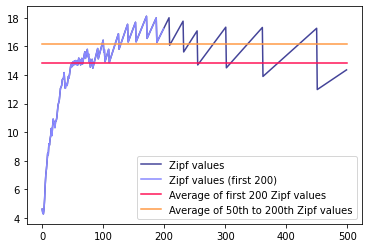

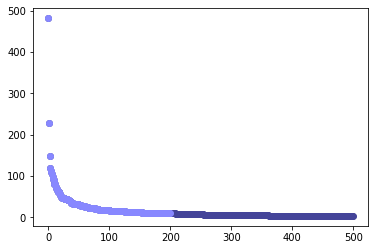

In [16]:
print("Number of all valid words found in text:         ", wojnicz_count)
plot_zipf(wojnicz_zipf, "wojnicz")
plot_occ(wojnicz_occ, "wojnicz")

## Converting and analyzing real-world language

Text content of a selected source is converted to simillar format as the source text in order to analyze it in the same way.  
After that, it is used to calculate the same statistics as with the previous text.

Converted text is saved to <code>words_real.txt</code>, one word per line.

In [17]:
# load text from file
text = open(REAL_INPUT_FILE, 'r', encoding="utf8").read().replace("\n", " ")

In [18]:
# convert text to list of words
parsed = ""

for char in text:
    if char == ' ' or re.match(VALID_CHAR_REAL_REGEX, char):
        parsed += char

parsed = parsed.split(" ")
words = []

for i, word in enumerate(parsed):
    if re.match("^"+VALID_CHAR_REAL_REGEX+"+$", word):
        words.append(word.upper())


In [19]:
# save file
save_to_file(words, "words_real.txt")

In [20]:
# analyze text
real_count = len(words)
real_occ = occurance_dict(words)
real_perc = occurance_percentage(words)
real_zipf = zipf_values(words)
real_zipf 

{'A': 2.566897918731417,
 'V': 4.816650148662042,
 'SE': 5.203171456888008,
 'DINOSAURŮ': 6.263627353815659,
 'NA': 7.185332011892963,
 'DINOSAUŘI': 6.422200198216055,
 'JE': 6.937561942517344,
 'S': 7.215064420218038,
 'Z': 7.314172447968286,
 'ŽE': 8.126858275520316,
 'O': 8.830525272547076,
 'U': 8.562933597621408,
 'I': 8.374628344895935,
 'VŠAK': 8.741328047571855,
 'JIŽ': 8.473736372646185,
 'TAKÉ': 8.087215064420219,
 'JAKO': 8.592666005946482,
 'JSOU': 8.919722497522299,
 'LET': 9.038652130822596,
 'AŽ': 9.316154608523291,
 'NAPŘÍKLAD': 9.781962338949455,
 'K': 9.81169474727453,
 'JEJICH': 10.029732408325073,
 'BYLY': 9.990089197224975,
 'VE': 9.910802775024777,
 'DRUHŮ': 10.049554013875124,
 'ROKU': 9.633300297324084,
 'NEBO': 9.712586719524282,
 'DO': 9.484638255698712,
 'BYLA': 9.514370664023787,
 'PŘED': 9.52428146679881,
 'NĚKTERÝCH': 9.514370664023787,
 'ALE': 9.81169474727453,
 'ZA': 10.109018830525272,
 'BYLI': 10.059464816650149,
 'ASI': 9.990089197224975,
 'STOLETÍ': 

Number of all valid words found in text:          10090
Average value of first 200 items (highlighted):   11.463875123885032
Average value of 50th to 200th item:              12.278625702015196
Index of first item to reach the average:         65


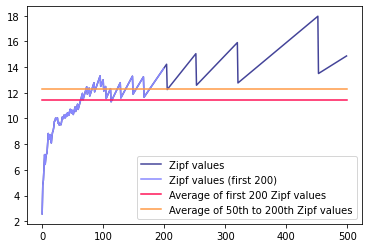

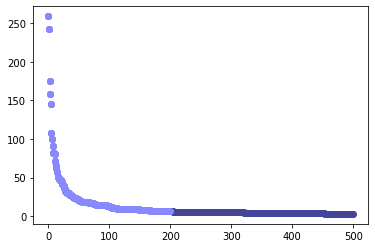

In [21]:
graph_name = re.sub("^inputs\\\\", "", re.sub("\\.txt$", "", REAL_INPUT_FILE))

print("Number of all valid words found in text:         ", real_count)
plot_zipf(real_zipf, graph_name)
plot_occ(real_occ, graph_name)

## Common analysis

Statistics are analyzed together for comparison.  
In addition, real-world language source is trimmed to contain the exact same amount of words as the Wojnicz manuscript.

In [22]:
# analyze portion of real text of same length as wojnicz manuscrypt
rshort_occ = occurance_dict(words[:wojnicz_count])
rshort_perc = occurance_percentage(words[:wojnicz_count])
rshort_zipf = zipf_values(words[:wojnicz_count])

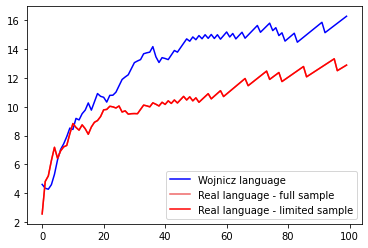

In [23]:
plt.plot(list(wojnicz_zipf.values())[:100], "#0000ff", label="Wojnicz language")
plt.plot(list(real_zipf.values())[:100], "#ee6666", label="Real language - full sample")
plt.plot(list(rshort_zipf.values())[:100], "#ff0000", label="Real language - limited sample")
plt.legend()

plt.savefig("outputs\\comparison_" + graph_name + ".png")

plt.show()

## Analysis of Bigrams
We use the previously prepared text to create bigrams for each valid pair of words in a text.
When creating bigrams, we skip words that are divided by special symbols like '.' or '(' so they won't be categorised as proper bigrams.

In [24]:
SENTENCE_STOPPER = "[\.()?!-+:;„“\"]"
parsedBg = ""
for char in text:
    if char == ' ' or re.match(VALID_CHAR_REAL_REGEX, char):
        parsedBg += char
    elif re.match(SENTENCE_STOPPER, char) and char != '':
        parsedBg += ' . '

parsedBg = parsedBg.split(" ")

In [25]:
wordsBg = []
for i, word in enumerate(parsedBg):
    if re.match("^"+VALID_CHAR_REAL_REGEX+"+$", word) or re.match(SENTENCE_STOPPER, word):
        wordsBg.append(word.lower())

biGrams = []

for i, word in enumerate(wordsBg):
    if word != '.' and wordsBg[i+1] != '.':
        biGrams.append((word, wordsBg[i+1]))

In [26]:
biGrams.sort()

In [27]:
def bigram_prob(words, searched):
    searchable = []
    ret_dict = {}
    for pair in words:
        if pair[0] == searched:
            searchable.append(pair)
    for pair in searchable:
        if pair[1] in ret_dict:
            ret_dict[pair[1]] += 1
        else:
            ret_dict[pair[1]] = 1

    words_count = len(searchable)+1
    for x in ret_dict.keys():
        ret_dict[x] /= words_count
    return dict(sorted(ret_dict.items(), key=lambda item: item[1], reverse=True))

For chosen word, the output of the function is a dictionary
with each word that can occur after our word, as well as the
probability of occurring (bigram probability formula).

In [29]:
dictionary = bigram_prob(biGrams, 'o')
print(dictionary)

{'tom': 0.05, 'jejich': 0.025, 'možném': 0.025, 'objevu': 0.025, 'průměru': 0.025, 'půl': 0.025, 'anatomii': 0.0125, 'až': 0.0125, 'dalších': 0.0125, 'desítky': 0.0125, 'dinosaurech': 0.0125, 'dinosaury': 0.0125, 'dinosauří': 0.0125, 'dnes': 0.0125, 'druhohorních': 0.0125, 'duté': 0.0125, 'dílo': 0.0125, 'fiktivní': 0.0125, 'historicky': 0.0125, 'její': 0.0125, 'katastrofě': 0.0125, 'kilometrů': 0.0125, 'konečná': 0.0125, 'kosti': 0.0125, 'krátkodobosti': 0.0125, 'křídové': 0.0125, 'metrů': 0.0125, 'milionech': 0.0125, 'milionů': 0.0125, 'mládě': 0.0125, 'množství': 0.0125, 'monofyletickou': 0.0125, 'možné': 0.0125, 'nejisté': 0.0125, 'nich': 0.0125, 'náhodná': 0.0125, 'ní': 0.0125, 'obrovitého': 0.0125, 'peří': 0.0125, 'podobě': 0.0125, 'pohlavních': 0.0125, 'pohlaví': 0.0125, 'pohřebiště': 0.0125, 'potenciální': 0.0125, 'pouhé': 0.0125, 'pozůstatky': 0.0125, 'první': 0.0125, 'rody': 0.0125, 'rok': 0.0125, 'roku': 0.0125, 'rozšíření': 0.0125, 'rychlém': 0.0125, 'skutečném': 0.0125, 's